# Part 4

# Import Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q tflearn

In [ ]:
from tensorflow.keras.layers import Flatten, Dense,Dropout,BatchNormalization,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,LearningRateScheduler,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

from tensorflow.keras import regularizers, optimizers
from keras.layers import Input,Lambda,Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from keras.callbacks import EarlyStopping
from keras.models import model_from_json

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler
import tflearn.datasets.oxflower17 as oxflower17
from tensorflow.keras.utils import to_categorical


import tensorflow_hub as hub
from skimage.io import imshow, imread
from scipy.signal import convolve2d
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tflearn
import cv2
import os





In [ ]:
os.chdir('/content/drive/MyDrive/AIML/ComputerVision/Part4')

# **Import the data. Analyse the dimensions of the data**

As from below . We have 1360 Images with 3 Channels and Size (224,224)

and we have 16 Labels as from Y

In [ ]:
# the data, shuffled and split between train and test sets
# (X_train, y_train), (X_test, y_test) = oxflower17.load_data()
X, Y = oxflower17.load_data()

In [ ]:
print(X.shape)
print(Y.shape)

(1360, 224, 224, 3)
(1360,)


In [ ]:
print(Y.min())

0


Here we are preprocessing the Data using ImageDataGenerator

# **Data Visualization.**



1.   Display the images
2.   Display the labels
3.   Display images vs labels
4.   Apply different filters [ for example: blur, contour, edge detection, emboss, smooth etc.] on the images and
display the image.



Label: 0


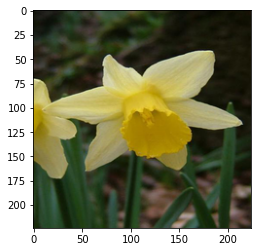

In [ ]:
print("Label: {}".format(Y[8]))
plt.imshow(X[8], cmap='gray')

5 7 8 2 6 15 8 0 7 1 
16 11 15 9 1 11 16 13 9 1 
8 0 12 9 7 11 0 8 5 12 
16 10 0 8 13 3 10 12 12 11 
16 5 16 15 6 11 10 12 1 1 
15 6 10 3 3 6 8 2 7 3 
7 16 4 7 13 9 1 4 16 13 
3 4 5 15 9 3 6 11 12 8 
9 3 1 1 11 15 12 2 0 11 
5 7 10 3 1 5 1 2 14 14 


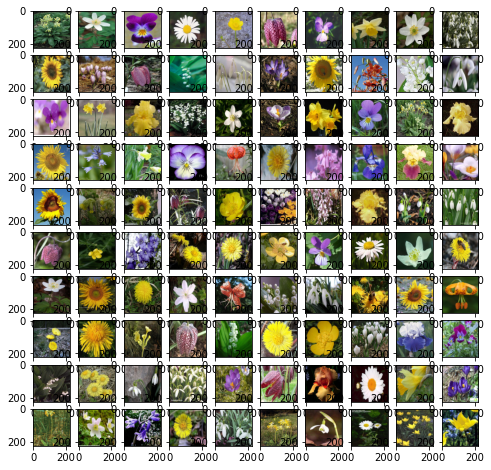

In [ ]:
fig=plt.figure(figsize=(8, 8))
columns = 10
rows = 10

for i in range(1, columns*rows + 1):
    img = X[i]
    fig.add_subplot(rows, columns, i)
    print (Y[i], end=' ')
    if i % columns == 0:
      print ("")
    plt.imshow(img, cmap='gray')

plt.show()

In [ ]:
# Loading single image and Applying ImageDatagenerator
datagen = ImageDataGenerator(rotation_range=90,
                            shear_range = 0.2,
                            zoom_range = [0.5,1.0],
                            horizontal_flip = True,
                            fill_mode='nearest',
                            width_shift_range=[-200,200],
                            height_shift_range=0.3,
                             brightness_range=[0.2,0.8])

(224, 224, 3)


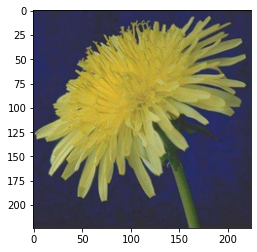

[0.7294118  0.6627451  0.22745098]
Red channel


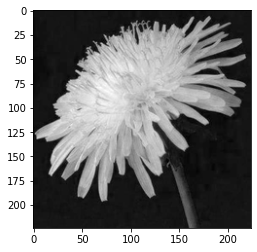

Green channel


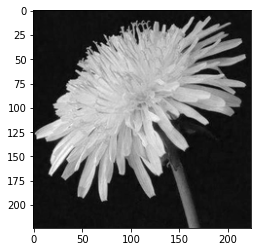

Blue channel


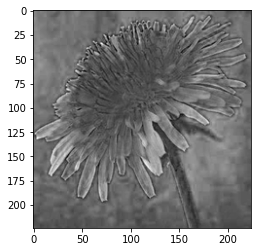

In [ ]:

print(X[0].shape)
plt.imshow(X[0])
plt.show()

# Check the three channel values at any pixel
print(X[0][100,100,:])

# Red Channel
print('Red channel')
plt.imshow(X[0][:,:,0],cmap='gray')
plt.show()

# Green Channel
print('Green channel')
plt.imshow(X[0][:,:,1],cmap='gray')
plt.show()

# Blue Channel
print('Blue channel')
plt.imshow(X[0][:,:,2],cmap='gray')
plt.show()

Horizontal edges Detection on Red Channel


<function matplotlib.pyplot.show>

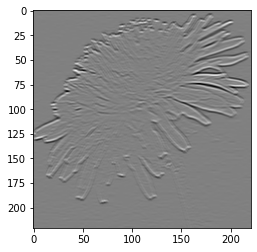

In [ ]:
# The following kernel is designed to bring out horizontal edges
print('Horizontal edges Detection on Red Channel')
kernel = np.array([[-1,-1,-1,-1],
                   [1,1,1,1],
                   [1,1,1,1],
                   [-1,-1,-1,-1]])

hor_edges = convolve2d(X[0][:,:,0], kernel, mode = 'valid')
plt.imshow(hor_edges,cmap='gray')
plt.show

Edge Detection on Green Channel


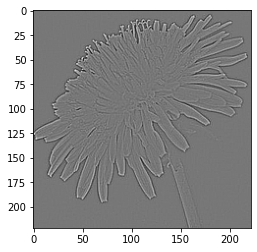

In [ ]:
# outline kernel - used for edge detection
print('Edge Detection on Green Channel')
kernel = np.array([[-1,-1,-1],
                   [-1,8,-1],
                   [-1,-1,-1]])

# we use 'valid' which means we do not add zero padding to our image
edges = convolve2d(X[0][:,:,1], kernel, mode = 'valid')

plt.imshow(edges,cmap='gray')

Blurred Visualization on Blue channel:


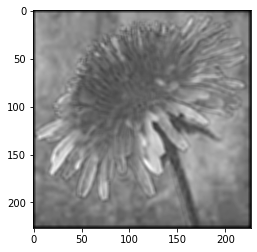

In [ ]:
print('Blurred Visualization on Blue channel:')
kernel = 1./16 *np.array([[1,1,1,1],
                   [1,1,1,1],
                   [1,1,1,1],
                   [1,1,1,1]])

blurred = convolve2d(X[0][:,:,2], kernel)
plt.imshow(blurred,cmap='gray')

In [ ]:
print(X[8].shape)

(224, 224, 3)


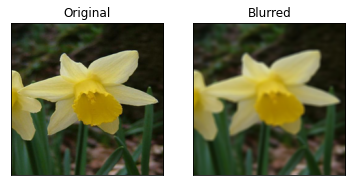

In [ ]:
img1=X[8]
blur = cv2.GaussianBlur(img1,(5,5),10)

plt.subplot(121),plt.imshow(img1),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(blur),plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.show()

# Preprocessing the data for Supervised Learning - Here not using ImageDataGenerator

### **Random Forest**

Without ImageDataGenerator

In [ ]:
# Reshape and normalize the data useful for Supervised Learning and Neural Networks - 224*224*3= 150528
print("Before Train Set:",X.shape)
x_SL_random = X.reshape(1360, 150528)
print("After Train Set:",x_SL_random.shape)

Before Train Set: (1360, 224, 224, 3)
After Train Set: (1360, 150528)


In [ ]:
scaler = MinMaxScaler()
x_SL_random_scaled=scaled = scaler.fit_transform(x_SL_random)

In [ ]:
print(X.std())
print(x_SL_random_scaled.std())

0.27128598
0.2712925


In [ ]:
#Split data into train and validation
X_train_random, X_val_random, y_train_random, y_val_random = train_test_split(x_SL_random_scaled,Y,test_size=0.3)

In [ ]:
# use a full grid over all parameters
param_grid_rand = {"max_depth": [3, None],
              "max_features": [1,  20],
              "min_samples_split": [2,  20],
              "min_samples_leaf": [1,  20],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

In [ ]:
randomforest = RandomForestClassifier(n_estimators=50)
random_forest = RandomizedSearchCV(randomforest, param_distributions=param_grid_rand, n_iter=10)
random_forest.fit(X_train_random, y_train_random)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [ ]:
print(random_forest.score(X_train_random, y_train_random))
print(random_forest.score(X_val_random, y_val_random))

0.9978991596638656
0.4362745098039216


### **Neural Network**

In [ ]:
# Reshape and normalize the data useful for Supervised Learning and Neural Networks - 224*224*3= 150528
print("Before Train Set:",X.shape)
x_NN = X.reshape(1360, 150528)
print("After Train Set:",x_NN.shape)

Before Train Set: (1360, 224, 224, 3)
After Train Set: (1360, 150528)


In [ ]:

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)



In [ ]:
X_train_NN, X_val_NN, y_train_NN, y_val_NN = train_test_split(x_NN,Y,test_size=0.3)

In [ ]:
# Do onehot encoding to convert Y train - Here Converting into 17
y_train_NN = to_categorical(y_train_NN, num_classes=17)
y_val_NN = to_categorical(y_val_NN, num_classes=17)
print('Before::',Y.shape)
print('After : ', y_train_NN.shape)
print('After : ', y_val_NN.shape)

Before:: (1360,)
After :  (952, 17)
After :  (408, 17)


In [ ]:
NN_model = Sequential()
NN_model.add(Flatten())
NN_model.add(Dense(32, activation="relu"))
NN_model.add(Dropout(0.2))
NN_model.add(Dense(16, activation="sigmoid"))
NN_model.add(BatchNormalization())

NN_model.add(Dense(17, activation="softmax"))

In [ ]:
learning_rate=0.01
adam = optimizers.Adam(lr=learning_rate)

In [ ]:
# Compile the model
NN_model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='sgd')


In [ ]:
#Early Stopping
callback = EarlyStopping(monitor = 'accuracy',min_delta = 0.001,patience = 5, verbose = 1,restore_best_weights = True)
#callback = LearningRateScheduler(scheduler)

In [ ]:
# Fit the model
history_NN= NN_model.fit(x=X_train_NN, y=y_train_NN, batch_size=500, epochs=200, validation_data=(X_val_NN, y_val_NN),callbacks=[callback])

Train on 952 samples, validate on 408 samples
Epoch 1/200
952/952 [==============================] - 1s 1ms/sample - loss: 3.1155 - acc: 0.0651 - val_loss: 2.9264 - val_acc: 0.0466
Epoch 2/200


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


952/952 [==============================] - 1s 935us/sample - loss: 2.8236 - acc: 0.1176 - val_loss: 2.8562 - val_acc: 0.0735
Epoch 3/200
952/952 [==============================] - 1s 919us/sample - loss: 2.7493 - acc: 0.1418 - val_loss: 2.9025 - val_acc: 0.0466
Epoch 4/200
952/952 [==============================] - 1s 915us/sample - loss: 2.7006 - acc: 0.1618 - val_loss: 2.9057 - val_acc: 0.0466
Epoch 5/200
952/952 [==============================] - 1s 929us/sample - loss: 2.7596 - acc: 0.1418 - val_loss: 2.8515 - val_acc: 0.0466
Epoch 6/200
952/952 [==============================] - 1s 903us/sample - loss: 2.6230 - acc: 0.1576 - val_loss: 2.8761 - val_acc: 0.0833
Epoch 7/200
952/952 [==============================] - 1s 919us/sample - loss: 2.8629 - acc: 0.1040 - val_loss: 2.8638 - val_acc: 0.0515
Epoch 8/200
952/952 [==============================] - 1s 901us/sample - loss: 2.7393 - acc: 0.1345 - val_loss: 2.8116 - val_acc: 0.0466
Epoch 9/200
952/952 [==============================] 

### **Convolutional Neural Network**

Using ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
    validation_split=0.2, 
    rescale=1./255,
    rotation_range=40,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest',
     width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.2,0.8]
)


test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split = 0.5,
                                   rotation_range=30,
                            shear_range = 0.2,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            fill_mode='nearest',
                            width_shift_range=0.3,
                            height_shift_range=0.3,
                             brightness_range=[0.2,0.8])

In [ ]:
#Normalize the Training Set
x_CNN = X.astype('float32')

x_CNN /= 255
print(x_CNN.shape)
print(Y.shape)

(1360, 224, 224, 3)
(1360,)


In [ ]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/AIML/ComputerVision/Part4/17flowers/jpg',
                                       target_size=(128, 128),
                                                batch_size=32,
                                     class_mode='categorical',
                                            subset='training')

validation_set = test_datagen.flow_from_directory('/content/drive/MyDrive/AIML/ComputerVision/Part4/17flowers/jpg',
                                        target_size=(128, 128),
                                                 batch_size=32,
                                      class_mode='categorical',
                                               shuffle = False,
                                           subset='validation')

Found 1088 images belonging to 17 classes.
Found 680 images belonging to 17 classes.


In [ ]:
model_CNN = Sequential()

model_CNN.add(Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(128, 128, 3)))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPooling2D(pool_size=(2,2)))

model_CNN.add(Dropout(0.2))

model_CNN.add(Conv2D(filters=64, kernel_size=3, activation="relu"))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPooling2D(pool_size=(2,2)))

model_CNN.add(Dropout(0.2))

model_CNN.add(Conv2D(filters=128, kernel_size=3, activation="relu"))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPooling2D(pool_size=(2,2)))

model_CNN.add(Conv2D(filters=128, kernel_size=2, activation="relu"))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPooling2D(pool_size=(2,2)))

model_CNN.add(Flatten())
model_CNN.add(Dense(32, activation="relu"))
model_CNN.add(Dropout(0.2))
model_CNN.add(Dense(16, activation="sigmoid"))
model_CNN.add(BatchNormalization())
model_CNN.add(Dense(17, activation="softmax"))

In [ ]:
learning_rate=0.01
sgd = optimizers.Adam(lr=learning_rate)

In [ ]:
# Compile the model
model_CNN.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=sgd)

In [ ]:
callback = EarlyStopping(monitor = 'accuracy',min_delta = 0.001,patience = 5, verbose = 1,restore_best_weights = True)

In [ ]:
model_CNN.fit_generator(training_set,
                    steps_per_epoch=len(training_set),
                    epochs=30,
                    validation_data=validation_set)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/30
34/34 [==============================] - ETA: 0s - batch: 16.5000 - size: 32.0000 - loss: 2.9282 - acc: 0.0956 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


34/34 [==============================] - 504s 15s/step - batch: 16.5000 - size: 32.0000 - loss: 2.9282 - acc: 0.0956 - val_loss: 2.9098 - val_acc: 0.0647
Epoch 2/30
34/34 [==============================] - 67s 2s/step - batch: 16.5000 - size: 32.0000 - loss: 2.6516 - acc: 0.1369 - val_loss: 2.6053 - val_acc: 0.0971
Epoch 3/30
34/34 [==============================] - 67s 2s/step - batch: 16.5000 - size: 32.0000 - loss: 2.6211 - acc: 0.1369 - val_loss: 2.7676 - val_acc: 0.0809
Epoch 4/30
34/34 [==============================] - 66s 2s/step - batch: 16.5000 - size: 32.0000 - loss: 2.5500 - acc: 0.1342 - val_loss: 2.9328 - val_acc: 0.0662
Epoch 5/30
34/34 [==============================] - 67s 2s/step - batch: 16.5000 - size: 32.0000 - loss: 2.5164 - acc: 0.1461 - val_loss: 2.4394 - val_acc: 0.1221
Epoch 6/30
34/34 [==============================] - 67s 2s/step - batch: 16.5000 - size: 32.0000 - loss: 2.4463 - acc: 0.1480 - val_loss: 2.5731 - val_acc: 0.1191
Epoch 7/30
34/34 [=============

### **Transfer Learning**

In [ ]:
os.chdir('/content/drive/MyDrive/AIML/ComputerVision/Part4')

In [ ]:
training_set_transfer = train_datagen.flow_from_directory('/content/drive/MyDrive/AIML/ComputerVision/Part4/17flowers/jpg',
                                       target_size=(224, 224),
                                                batch_size=32,
                                     class_mode='categorical',
                                            subset='training')

validation_set_transfer = test_datagen.flow_from_directory('/content/drive/MyDrive/AIML/ComputerVision/Part4/17flowers/jpg',
                                        target_size=(224, 224),
                                                 batch_size=32,
                                      class_mode='categorical',
                                           subset='validation')

Found 1088 images belonging to 17 classes.
Found 680 images belonging to 17 classes.


In [ ]:
IMAGE_SIZE=[224,224]
URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
resnet = hub.KerasLayer(URL, input_shape=(224, 224, 3))
#resnet = ResNet50(input_shape=IMAGE_SIZE + [3] ,weights='imagenet',include_top=False,pooling='avg')

In [ ]:
resnet.trainable = False

In [ ]:
transfermodel=Sequential()
transfermodel.add(resnet)
transfermodel.add(Dense(17, activation="softmax"))

In [ ]:
for layers in transfermodel.layers:
    if('dense' not in layers.name):
        layers.trainable = False


In [ ]:
transfermodel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_7 (Dense)              (None, 17)                21777     
Total params: 2,279,761
Trainable params: 21,777
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
learning_rate=0.1
#sgd = optimizers.Adam(lr=learning_rate)
sgd= optimizers.SGD(momentum=0.01, nesterov=True)

In [ ]:
# Compile the model
transfermodel.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=sgd)

In [ ]:
transfermodelhistory= transfermodel.fit_generator(training_set_transfer,
                    steps_per_epoch=len(training_set_transfer),
                    epochs=30,
                    validation_data=validation_set_transfer)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/30
34/34 [==============================] - 96s 3s/step - batch: 16.5000 - size: 32.0000 - loss: 0.3731 - acc: 0.9099 - val_loss: 0.3663 - val_acc: 0.9044
Epoch 2/30
34/34 [==============================] - 91s 3s/step - batch: 16.5000 - size: 32.0000 - loss: 0.3854 - acc: 0.9118 - val_loss: 0.3518 - val_acc: 0.9206
Epoch 3/30
34/34 [==============================] - 91s 3s/step - batch: 16.5000 - size: 32.0000 - loss: 0.3901 - acc: 0.9044 - val_loss: 0.3413 - val_acc: 0.9176
Epoch 4/30
34/34 [==============================] - 91s 3s/step - batch: 16.5000 - size: 32.0000 - loss: 0.3712 - acc: 0.9154 - val_loss: 0.3239 - val_acc: 0.9206
Epoch 5/30
34/34 [==============================] - 91s 3s/step - batch: 16.5000 - size: 32.0000 - loss: 0.3655 - acc: 0.9182 - val_loss: 0.3355 - val_acc: 0.9147
Epoch 6/30
34/34 [==============================] - 91s 3s/step - batch: 16.5000 - size: 32.0000 - loss: 0.3601 - acc: 0.9182 - val_loss: 0.3595 - val_acc: 0.9029
Epoch 7/30
34/34 [====

(0.1, 1.0)

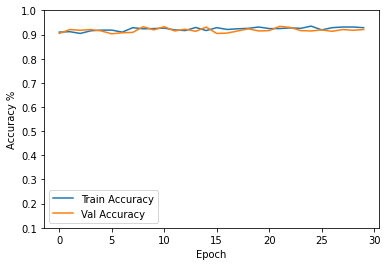

In [ ]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.plot(transfermodelhistory.epoch, np.array(transfermodelhistory.history['acc']),
label='Train Accuracy')
plt.plot(transfermodelhistory.epoch, np.array(transfermodelhistory.history['val_acc']),
label = 'Val Accuracy')
plt.legend()
plt.ylim([0.1, 1])

Here as compared to CNN , in the transfer learning the  accuracy of the train test increases from 16% to (80-90)%



# Pickle the Model

In [ ]:
os.chdir('/content/drive/MyDrive/AIML/ComputerVision/Part4')

In [ ]:
model_json = transfermodel.to_json()
with open("ComputerVision_Part4.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
transfermodel.save_weights("ComputerVision_Part4.h5")
print("Saved model to disk")

Saved model to disk


# Unpickle the Model and Predict the image 

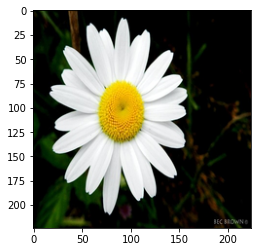

In [ ]:
predict_img= load_img('/content/drive/MyDrive/AIML/ComputerVision/Part4/Prediction - Flower.jpg')
plt.imshow(predict_img, cmap='gray')

In [ ]:
x2=img_to_array(predict_img)
x2.shape
x2=cv2.resize(x2,(224,224))
x2.shape


(224, 224, 3)

In [ ]:
x2=x2.reshape((1,)+x2.shape) #  Reshaping the image in 4 D array (i.ee 3 channel)

print(x2.shape) 

(1, 224, 224, 3)


In [ ]:
x2=x2/255

In [ ]:
# Open the file as readonly
# load json and create model
json_file = open('/content/drive/MyDrive/AIML/ComputerVision/Part4/ComputerVision_Part4.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json,custom_objects={'KerasLayer': hub.KerasLayer})
loaded_model.load_weights("/content/drive/MyDrive/AIML/ComputerVision/Part4/ComputerVision_Part4.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
print(x2.shape)
print("Prediction label for above image: ", np.argmax(loaded_model.predict(x2)))


(1, 224, 224, 3)
Prediction label for above image:  2


Label is 2 - Images Check from Original dataset

5 7 
8 2 


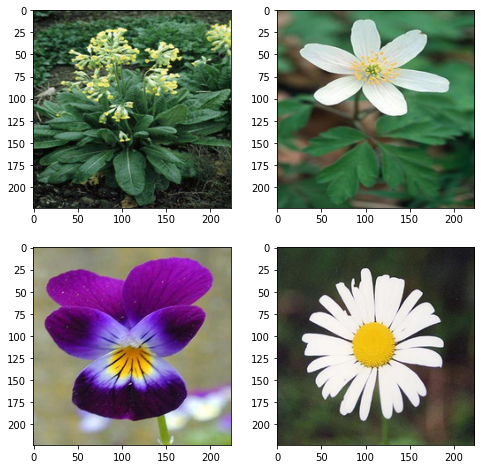

In [ ]:
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 2

for i in range(1, columns*rows + 1):
    img = X[i]
    fig.add_subplot(rows, columns, i)
    print (Y[i], end=' ')
    if i % columns == 0:
      print ("")
    plt.imshow(img, cmap='gray')

plt.show()

Therefore our model predicted correctly as 2 represents the same image from above label vs image plt

GUI - Done Front end and please refer GUI Folder

# Part 5  - strategy to maintain and support the AIML image classifier after it in production.

• Explain in depth your strategy to maintain and support the AIML image classifier after it in production.

1. How to deal with Unseen data - So we have to do Model Monitoring - that is retraining the model with new type of data
2. Use an agile development methodology for your ML - It should have managable sprints so that timely support will be given
3. Avoid Overfitting 


